In [1]:
import copy
from math import sqrt
import numpy as np
from operator import mul
from scipy.stats import bernoulli, norm
import matplotlib.pyplot as plt
import functools
%matplotlib inline 

In [2]:
1.0/np.inf

0.0

In [3]:
d = 1
N = 50
w = 0.5
clutter_var = 10
prior_var = 100
tol = 10**4

In [4]:
def likelihood_aux(point, mu, variances):
    # multiply through the list univariates from all the parameters
    if variances < 0:
        x = functools.reduce(mul, ((norm.pdf(pt_uni, mu_uni, sd)
                        for (pt_uni, mu_uni, sd)
                        in zip(point, mu, -np.sqrt(-variances)))))
    else:
        x = functools.reduce(mul, ((norm.pdf(pt_uni, mu_uni, sd)
                        for (pt_uni, mu_uni, sd)
                        in zip(point, mu, np.sqrt(variances)))))
    return x

In [5]:
def gen_data(N, d, clutter_var, w, prior_var):
    # Define relevant distributions.
    ris_clutter = bernoulli(w).rvs
    clutter_uni = norm(0, sqrt(clutter_var))
    rclutter = lambda: [clutter_uni.rvs() for _ in range(d)]  # random variable describing clutter
    
    prior = norm(0., sqrt(prior_var))
    # Sample from the distributions.
    # mean in each dimension
    x = np.array([prior.rvs() for _ in range(d)])
    x_rvss = [norm(x_i).rvs for x_i in x]
    rx = lambda: [xrvs() for xrvs in x_rvss] # random variable describing target function
    
    # populate data
    data = np.vstack([(rclutter() if ris_clutter() else rx()) for _ in range(N)])

    return x, data

In [6]:
def generate_data(true_mean, N, d, clutter_var, w, prior_var):
    # Define relevant distributions.
    ris_clutter = bernoulli(w).rvs
    clutter_uni = norm(0, sqrt(clutter_var))
    rclutter = lambda: [clutter_uni.rvs() for _ in range(d)]  # random variable describing clutter
    
    prior = norm(0., sqrt(prior_var)) 

    # Sample from the distributions.
    
    # choose mean in each dimension
    x = np.array([prior.rvs() for _ in range(d)])
    x = true_mean
    x_rvss = [norm(x_i).rvs for x_i in x]
    rx = lambda: [xrvs() for xrvs in x_rvss] # random variable describing target function
    
    # populate data
    data = np.vstack([(rclutter() if ris_clutter() else rx()) for _ in range(N)])

    return x, data

[2]


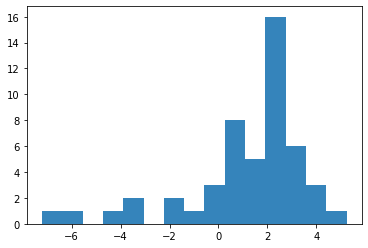

In [7]:
# generate data

# x_true, data = gen_data(N, d, clutter_var, w, prior_var)

target = np.array([2])
x_true, data = generate_data(target, N, d, clutter_var, w, prior_var)

print(x_true)

plt.hist(data, bins=15, alpha=0.9)
plt.show()

In [8]:
def param_dist(new, old):
    """Measures distance between two vectors of parameters."""
    new_finfo = np.finfo(new.dtype)
    new_clipped = np.clip(new, new_finfo.min, new_finfo.max)
    old_finfo = np.finfo(old.dtype)
    old_clipped = np.clip(old, old_finfo.min, old_finfo.max)
    return max(np.sum(np.atleast_2d((new_clipped - old_clipped) ** 2), axis=1))

In [9]:
from scipy.stats import norm

def update_plot(data, m_new, v_new, cavity_m, cavity_v, mi, vi, factors_used, x_true, pclutter, m_old, v_old):

    global w
    min_x = np.min(data, axis=0)[0]
    max_x = np.max(data, axis=0)[0]
    x = np.linspace(max_x + 1.1 * (min_x - max_x),
                         min_x + 1.5 * (max_x - min_x), 201)
    
    plt.figure(figsize=(20,10))
    
    # Draw the new posterior.
    post_pdf = norm(m_new[0], sqrt(v_new)).pdf
    plt.plot(x, list(map(post_pdf, x)), label="new posterior")
    
    # Draw the old posterior.
    post_old_pdf = norm(m_old[0], sqrt(v_old)).pdf
    plt.plot(x, list(map(post_old_pdf, x)), label="old posterior")
    
    # Draw the points used.
    plt.plot((x_true[0], x_true[0]), (0, 1.5), label="target mean")
    plt.scatter(data[factors_used, 0], np.zeros(len(factors_used)), color='b', label="used points")

    # Draw the cavity distribution.
    if cavity_v < 0:
        neg_var = -sqrt(-cavity_v)
        plt.plot(x, mlab.normpdf(x, cavity_m[0], neg_var), label="cavity")
    else:
        plt.plot(x, list(map(norm(cavity_m[0], sqrt(cavity_v)).pdf, x)), label="cavity")
    
    # Draw the last point's distribution.
    last_point = data[factors_used[-1]][0]
    plt.scatter([last_point], [0.], color='g', label="latest data point")
    print("mean of factor ", mi[factors_used[-1], 0])
    if vi[factors_used[-1]] < 0:
        plt.plot(x, norm.pdf(x, mi[factors_used[-1], 0], -sqrt(-vi[factors_used[-1]])), label="updated factor")
    else:
        last_post_pdf = norm(mi[factors_used[-1], 0], sqrt(vi[factors_used[-1]])).pdf
        plt.plot(x, list(map(last_post_pdf, x)), label="updated factor")
    plt.legend()
    plt.show()

In [10]:
def plot_factors(data, x_true, m_0, v_0, mi, vi):
    y_1d = np.atleast_2d(data)[...,0]
    min_x = min(y_1d)
    max_x = max(y_1d)
    x = np.linspace(max_x + 1.1 * (min_x - max_x), min_x + 1.5 * (max_x - min_x), 201)

    plt.plot((x_true[0], x_true[0]), (0, 0.5), label="true x")
    plt.scatter(y_1d, np.zeros(data.shape[0]))
    prior = norm(m_0[0], sqrt(v_0)).pdf
    plt.plot(x, list(map(prior, x)), label="prior")

    for i, (mi, vi) in enumerate(zip(mi, vi)):
        if vi < 0:
            x_post = norm(mi[0], -sqrt(-vi)).pdf
            plt.plot(x, norm.pdf(x, mi[0], -sqrt(-vi)), label="true factor")
        else:
            x_post = norm(mi[0], sqrt(vi)).pdf
            plt.plot(x, list(map(x_post, x)))
    plt.legend()
    plt.show()

In [11]:
# Initialise the prior (not to change it ever more).
m0 = np.zeros(d)  # The prior of x shall be non-informative.
v0 = prior_var
s0 = (2 * np.pi * v0) ** (-.5 * d)

# Initialise data terms.
vi = np.repeat(np.infty, N)
mi = np.zeros((N, d))
si = np.ones(N)
old_vi = copy.copy(vi)
old_mi = copy.copy(mi)
old_si = copy.copy(si)

# Initialise posterior with prior 
m_new = m0
v_new = v0


d_zeros = np.zeros(d)
d_clutter_vars = np.repeat(clutter_var, d)
pclutter = lambda y: likelihood_aux(y, d_zeros, d_clutter_vars)

In [12]:
def is_inverse_diff(v1, v2):
    # check if inverse of the variances are same
    inv_v1 = 1. / v1
    inv_v2 = 1. / v2
    if inv_v1 == inv_v2:
        return False
    else:
        return True
    
    
def remove_factor(mi, vi, m_new, v_new):
    # remove factor from posterior
    inv_vi = 1. / vi
    inv_v_new = 1. / v_new
    cavity_v = 1. / (inv_v_new - inv_vi)
    cavity_m = cavity_v * (m_new * inv_v_new - mi * inv_vi)
    
    return cavity_m, cavity_v

def minimise_KL_divergence(data_point, cavity_m, cavity_v):
    
    Zi = ((1 - w) * likelihood_aux(data_point, cavity_m, np.repeat(cavity_v + 1., d)) + w * pclutter(data_point))
    r = 1. - w * pclutter(data_point) / Zi

    m_new = (cavity_m + r * cavity_v / (1. + cavity_v) * (data_point - cavity_m))

    v_new = (cavity_v - r * (cavity_v ** 2) / (cavity_v + 1.) +
               r * (1 - r) * cavity_v ** 2
               * np.sum((data_point - cavity_m) ** 2)
               / (d * (cavity_v + 1.) ** 2))
    
    return m_new, v_new, Zi


def update_approximate_factor(cavity_m, m_new, cavity_v, v_new, Zi):
    
    global d 

    inv_cavity_v = 1. / cavity_v
    inv_new_v = 1. / v_new
    
    if inv_new_v != inv_cavity_v:
        vi = 1. / (inv_new_v - inv_cavity_v)
    else:
        # division by zero
        vi = np.infty
        print("same variance from removing new approximate factor iiii")
    
    # problem 2
    # 0 * infinity
    if vi == np.infty and (inv_cavity_v == 0 or any(m_new == cavity_m)):
        mi = cavity_m
        # mi = vi * (inv_new_v * m_new - inv_cavity_v * cavity_m)
        print("0*infinity iiii")
        print(inv_cavity_v)
    else:
        mi = vi * (inv_new_v * m_new - inv_cavity_v * cavity_m)
        # mi_2 = cavity_m + (vi + cavity_v) * inv_cavity_v * (m_new - cavity_m)
    
    
    # calculate normalising constant
    m_prob = likelihood_aux(mi, cavity_m,np.repeat(vi + cavity_v, d))
    si = Zi / m_prob if m_prob > 0. else np.infty    

    return mi, vi, si

def check_convergence(mi, vi, si, old_mi, old_vi, old_si):

    dist = max(param_dist(new, old) for (new, old) in ((vi, old_vi), (mi, old_mi), (si, old_si)))
    print("m_new = ", m_new, " v_new = ", v_new)
    print("Maximum distance from last parameter values: ", dist)
    
    if dist <= tol:
        return True
    else:
        return False

Iteration  0
factor  0
factor  1
factor  2
factor  3
factor  4
factor  5
factor  6
factor  7
factor  8
factor  9
factor  10
factor  11
factor  12
factor  13
factor  14
factor  15
factor  16
factor  17
factor  18
factor  19
factor  20
factor  21
factor  22
factor  23
factor  24
factor  25
factor  26
factor  27
factor  28
factor  29
factor  30
factor  31
factor  32
factor  33
factor  34
factor  35
factor  36
factor  37
factor  38
factor  39
factor  40
factor  41
factor  42
factor  43
factor  44
factor  45
factor  46
factor  47
factor  48
factor  49
mean of factor  2.190843648587224


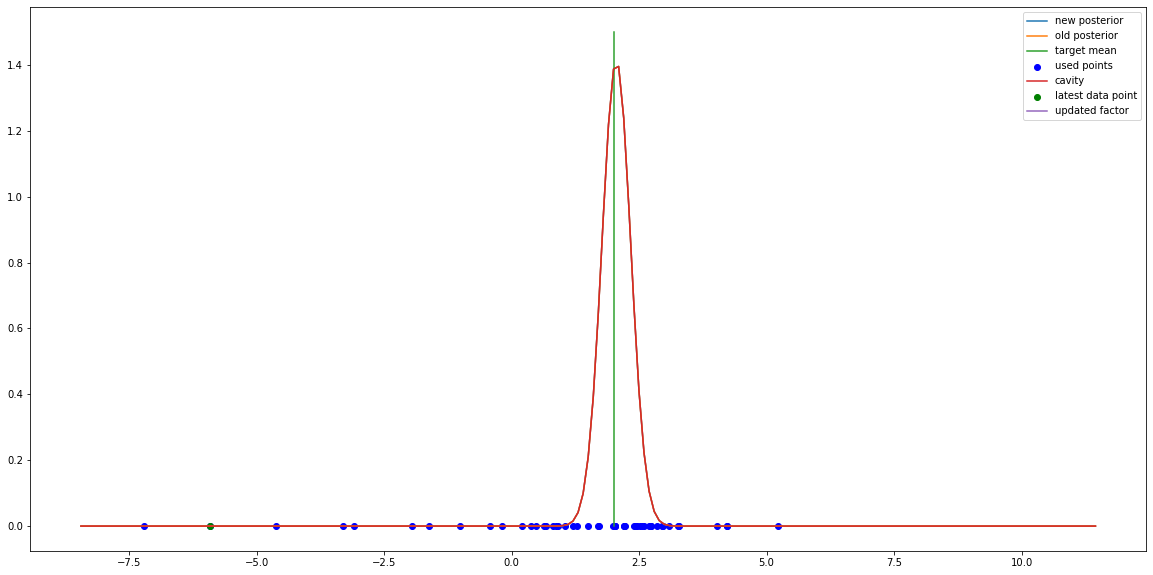

C:\Temp\ipykernel_17876\958118518.py:7: RuntimeWarning: overflow encountered in square
  return max(np.sum(np.atleast_2d((new_clipped - old_clipped) ** 2), axis=1))


m_new =  [2.05286203]  v_new =  0.07968986952615889
Maximum distance from last parameter values:  inf
Iteration  1
factor  0
factor  1
factor  2
factor  3
factor  4
factor  5
factor  6
factor  7
same variance from removing new approximate factor iiii
0*infinity iiii
14.365706570710143
factor  8
factor  9
factor  10
factor  11
factor  12
factor  13
factor  14
factor  15
factor  16
factor  17
factor  18
factor  19
factor  20
factor  21
factor  22
factor  23
factor  24
factor  25
factor  26
factor  27
factor  28
factor  29
factor  30
factor  31
factor  32
factor  33
factor  34
factor  35
factor  36
factor  37
factor  38
factor  39
factor  40
factor  41
factor  42
factor  43
factor  44
factor  45
factor  46
factor  47
factor  48
factor  49
mean of factor  2.3144569288389514


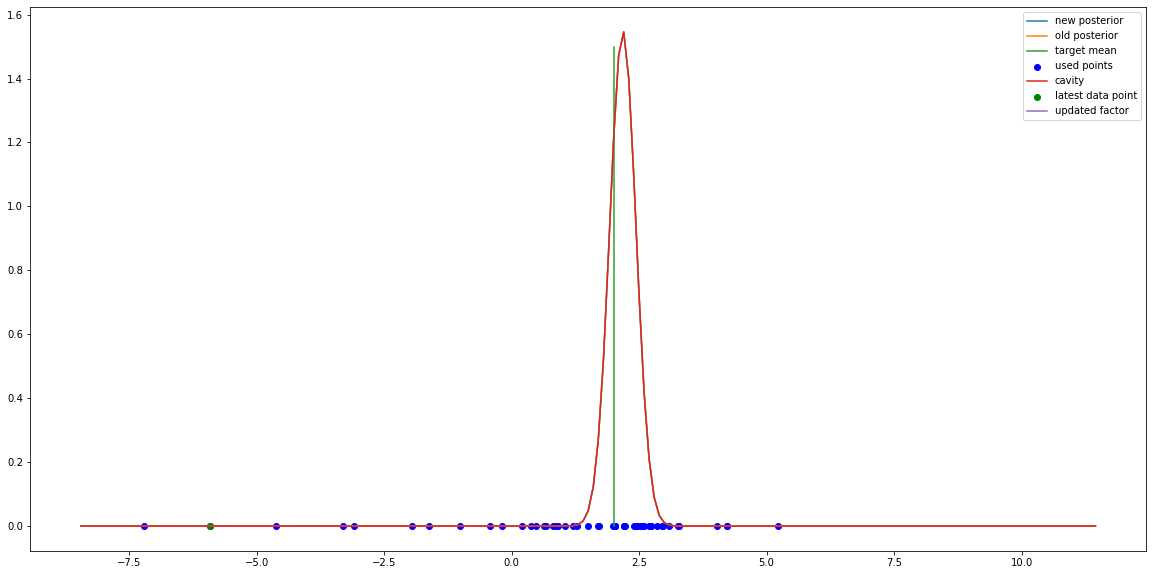

m_new =  [2.18051857]  v_new =  0.06631164576013901
Maximum distance from last parameter values:  inf
Iteration  2
factor  0
factor  1
factor  2
factor  3
factor  4
factor  5
factor  6
factor  7
same variance from removing new approximate factor iiii
0*infinity iiii
15.085983769735467
factor  8
factor  9
factor  10
factor  11
factor  12
factor  13
factor  14
factor  15
factor  16
factor  17
factor  18
factor  19
factor  20
factor  21
factor  22
factor  23
factor  24
factor  25
factor  26
factor  27
factor  28
factor  29
factor  30
factor  31
factor  32
factor  33
factor  34
factor  35
factor  36
factor  37
factor  38
factor  39
factor  40
factor  41
factor  42
factor  43
factor  44
factor  45
factor  46
factor  47
factor  48
factor  49
mean of factor  2.315758161671748


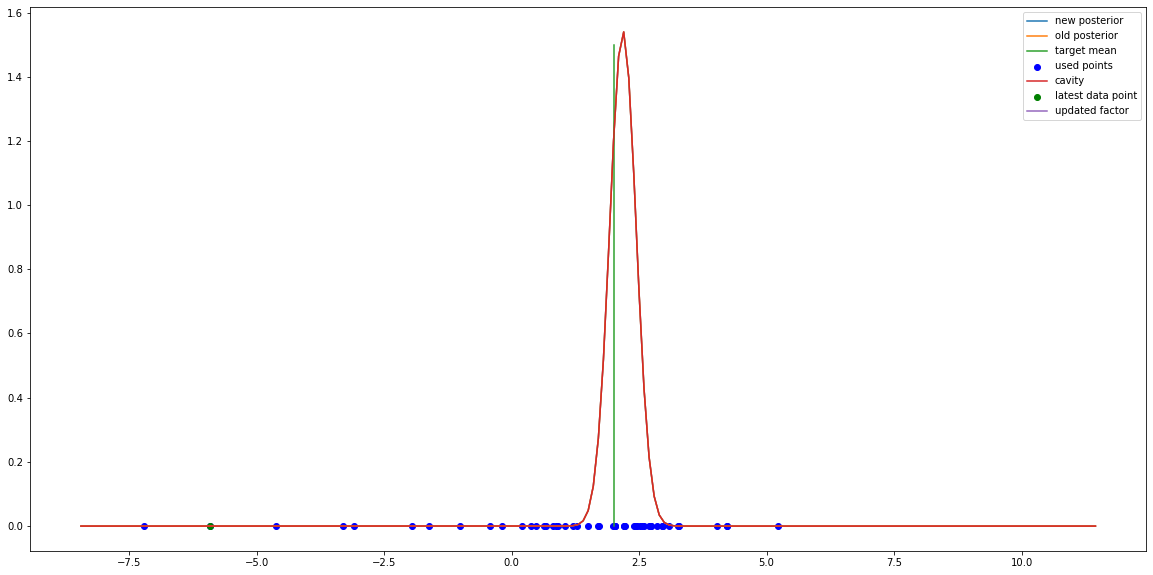

m_new =  [2.18162428]  v_new =  0.06689108638321563
Maximum distance from last parameter values:  inf
Iteration  3
factor  0
factor  1
factor  2
factor  3
factor  4
factor  5
factor  6
factor  7
same variance from removing new approximate factor iiii
0*infinity iiii
14.949929347012025
factor  8
factor  9
factor  10
factor  11
factor  12
factor  13
factor  14
factor  15
factor  16
factor  17
factor  18
factor  19
factor  20
factor  21
factor  22
factor  23
factor  24
factor  25
factor  26
factor  27
factor  28
factor  29
factor  30
factor  31
factor  32
factor  33
factor  34
factor  35
factor  36
factor  37
factor  38
factor  39
factor  40
factor  41
factor  42
factor  43
factor  44
factor  45
factor  46
factor  47
factor  48
factor  49
mean of factor  2.3156016504962644


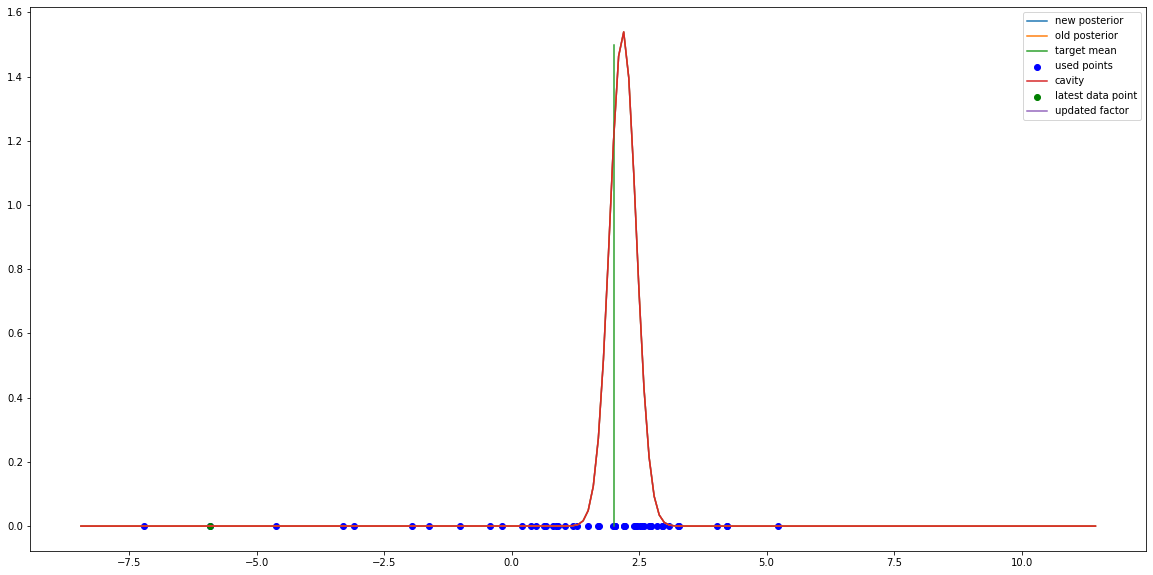

m_new =  [2.18158416]  v_new =  0.06689202445734903
Maximum distance from last parameter values:  29668508557050.1
Iteration  4
factor  0
factor  1
factor  2
factor  3
factor  4
factor  5
factor  6
factor  7
same variance from removing new approximate factor iiii
0*infinity iiii
14.949477927237737
factor  8
factor  9
factor  10
factor  11
factor  12
factor  13
factor  14
factor  15
factor  16
factor  17
factor  18
factor  19
factor  20
factor  21
factor  22
factor  23
factor  24
factor  25
factor  26
factor  27
factor  28
factor  29
factor  30
factor  31
factor  32
factor  33
factor  34
factor  35
factor  36
factor  37
factor  38
factor  39
factor  40
factor  41
factor  42
factor  43
factor  44
factor  45
factor  46
factor  47
factor  48
factor  49
mean of factor  2.315539033457249


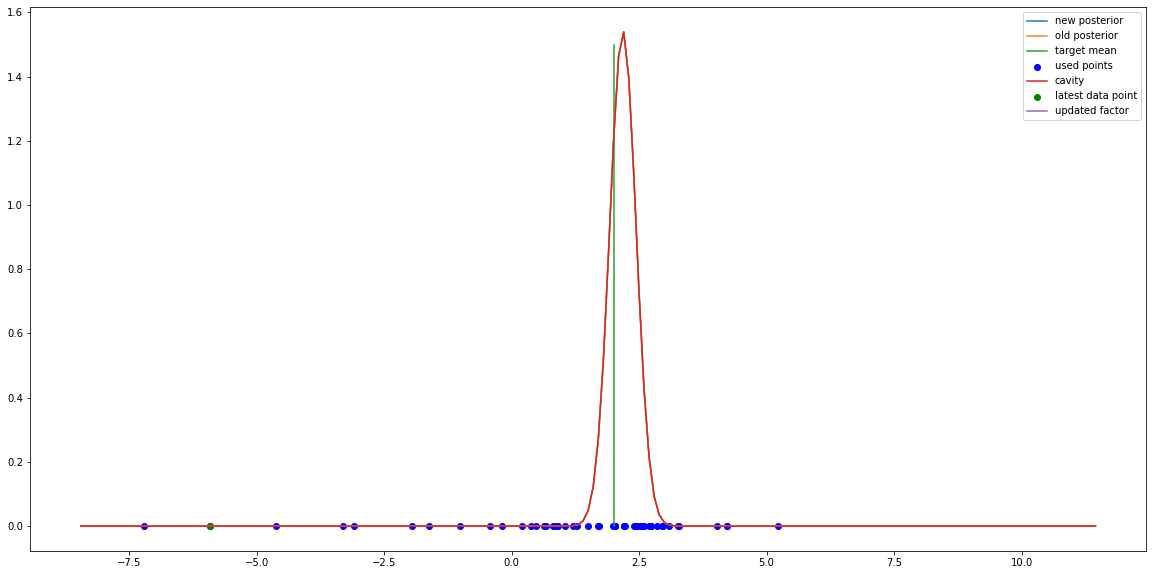

m_new =  [2.18158384]  v_new =  0.06689183551840336
Maximum distance from last parameter values:  605199498989.6694
Iteration  5
factor  0
factor  1
factor  2
factor  3
factor  4
factor  5
factor  6
factor  7
same variance from removing new approximate factor iiii
0*infinity iiii
14.949507651943774
factor  8
factor  9
factor  10
factor  11
factor  12
factor  13
factor  14
factor  15
factor  16
factor  17
factor  18
factor  19
factor  20
factor  21
factor  22
factor  23
factor  24
factor  25
factor  26
factor  27
factor  28
factor  29
factor  30
factor  31
factor  32
factor  33
factor  34
factor  35
factor  36
factor  37
factor  38
factor  39
factor  40
factor  41
factor  42
factor  43
factor  44
factor  45
factor  46
factor  47
factor  48
factor  49
mean of factor  2.3156877323420075


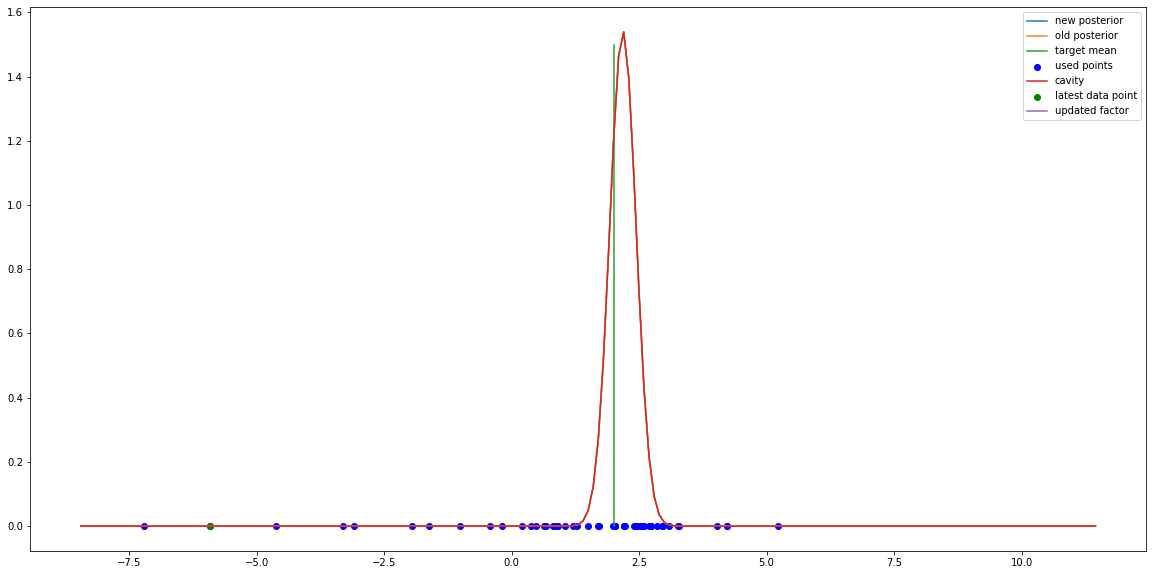

m_new =  [2.18158385]  v_new =  0.06689183530057823
Maximum distance from last parameter values:  38.85743433253016
Convergence reached.


In [13]:
# Outer loop
for iteration in range(10):
    print("Iteration ", iteration)

    factors_used = []

    for i in range(N):
        print ("factor ", i)
        
        m_old = m_new
        v_old = v_new
        ######################################################################################
        
        # Find the cavity distribution parameters.
        
        if is_inverse_diff(vi[i], v_new):
            cavity_m, cavity_v = remove_factor(mi[i], vi[i], m_new, v_new)
        else:
            print("Skipping ", i, " for division of zero when removing factor for cavity funtion iiii")
            continue
  
        ######################################################################################

        # minimise KL divergence, update posterior
        
        m_new, v_new, Zi = minimise_KL_divergence(data[i], cavity_m, cavity_v)

        ######################################################################################

        # Update/remove approximate factor fi from q_new (moment matched from min KL)    
        
        mi[i], vi[i], si[i] = update_approximate_factor(cavity_m, m_new, cavity_v, v_new, Zi)

        ######################################################################################    
        factors_used.append(i)
        ###################################################################################### 
    update_plot(data, m_new, v_new, cavity_m, cavity_v, mi, vi, factors_used, x_true, pclutter, m_old, v_old)
        
    # Check for convergence, after iteration
    if check_convergence(mi, vi, si, old_mi, old_vi, old_si):
        print("Convergence reached.")
        break
        
    old_vi = copy.copy(vi)
    old_mi = copy.copy(mi)
    old_si = copy.copy(si)

In [14]:
#######################################################################################################

# Compute the normalising constant for posterior

valid_factors = (vi > 0) & np.isfinite(si)
B = m_new.dot(m_new) / v_new - sum(m.dot(m) / v for (m, v) in
                             zip(mi[valid_factors], vi[valid_factors]))
Z = ((2 * np.pi * v_new) ** (.5 * d) * np.exp(.5 * B)
     * s0 * np.prod(si[valid_factors])
           * np.prod((2 * np.pi * vi[valid_factors]) ** (-.5 * d)))

In [15]:
print("Results:")
print("vi = ", vi)
print("mi = ", mi)
print("si = ", si)
print("m_posterior = ", m_new)
print("v_posterior = ", v_new)
print("B = ", B)
print("Z = ", Z)

Results:
vi =  [ 1.37557591e+00  1.42947249e+00 -2.01727676e+00  1.42427759e+00
  1.69042265e+00 -9.68542967e+03 -2.93700750e+00             inf
  1.27481148e+00  2.01515782e+00 -7.08033315e+06 -1.32418750e+00
 -9.97194553e+00 -1.96483457e+00  2.31635631e+00 -5.04396494e+00
 -2.16290922e+01  2.03967681e+00  2.08334264e+00  1.44818010e+00
  1.54018382e+00 -1.85695688e+00  1.31468925e+00  1.32391190e+00
  1.27531192e+00  6.72631993e+00 -2.11641978e+00 -2.13880039e+00
  1.29597635e+00  1.52700404e+00  1.35840437e+00 -1.89771922e+01
 -3.84035632e+00  1.29649598e+00  1.28158485e+00 -5.69020430e+01
  1.28784471e+00 -4.02995065e+03  5.71382622e+00  1.30277336e+00
 -3.89851839e+00  1.62900364e+00  1.29123894e+00  3.22828933e+00
  1.37609122e+00  1.27455425e+00  1.30201541e+00  1.29981543e+01
  1.29603038e+00 -2.09275076e+10]
mi =  [[ 2.76825508]
 [ 1.66726613]
 [ 0.25059978]
 [ 1.67677804]
 [ 3.33485918]
 [ 2.38340996]
 [ 4.13770297]
 [ 2.18158384]
 [ 2.20819616]
 [ 0.9688939 ]
 [ 2.34232286]


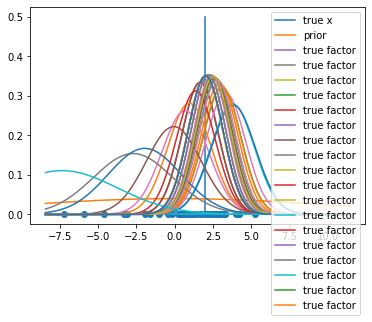

In [16]:
plot_factors(data, x_true, m0, v0, mi, vi)